In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('cancer_reg.csv', encoding='utf-8', encoding_errors='ignore')
df.head

<bound method NDFrame.head of       avgAnnCount  avgDeathsPerYear  TARGET_deathRate  incidenceRate  \
0     1397.000000               469             164.9     489.800000   
1      173.000000                70             161.3     411.600000   
2      102.000000                50             174.7     349.700000   
3      427.000000               202             194.8     430.400000   
4       57.000000                26             144.4     350.100000   
...           ...               ...               ...            ...   
3042  1962.667684                15             149.6     453.549422   
3043  1962.667684                43             150.1     453.549422   
3044  1962.667684                46             153.9     453.549422   
3045  1962.667684                52             175.0     453.549422   
3046  1962.667684                48             213.6     453.549422   

      medIncome  popEst2015  povertyPercent  studyPerCap           binnedInc  \
0         61898      2601

In [9]:
# 1. Basic Dataset Information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nBasic Statistics:")
df.describe()

Dataset Shape: (3047, 34)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              3047 non-null   float64
 1   avgDeathsPerYear         3047 non-null   int64  
 2   TARGET_deathRate         3047 non-null   float64
 3   incidenceRate            3047 non-null   float64
 4   medIncome                3047 non-null   int64  
 5   popEst2015               3047 non-null   int64  
 6   povertyPercent           3047 non-null   float64
 7   studyPerCap              3047 non-null   float64
 8   binnedInc                3047 non-null   object 
 9   MedianAge                3047 non-null   float64
 10  MedianAgeMale            3047 non-null   float64
 11  MedianAgeFemale          3047 non-null   float64
 12  Geography                3047 non-null   object 
 13  AvgHouseholdSize         3047 non-nul

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3.047000e+03,3047.000000,3047.000000,3047.000000,3047.000000,...,2438.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,606.338544,185.965868,178.664063,448.268586,47063.281917,1.026374e+05,16.878175,155.399415,45.272333,39.570725,...,48.453774,41.196324,36.252642,19.240072,83.645286,9.107978,1.253965,1.983523,51.243872,5.640306
std,1416.356223,504.134286,27.751511,54.560733,12040.090836,3.290592e+05,6.409087,529.628366,45.304480,5.226017,...,10.083006,9.447687,7.841741,6.113041,16.380025,14.534538,2.610276,3.517710,6.572814,1.985816
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,...,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38882.500000,1.168400e+04,12.150000,0.000000,37.700000,36.350000,...,41.000000,34.500000,30.900000,14.850000,77.296180,0.620675,0.254199,0.295172,47.763063,4.521419
50%,171.000000,61.000000,178.100000,453.549422,45207.000000,2.664300e+04,15.900000,0.000000,41.000000,39.600000,...,48.700000,41.100000,36.300000,18.800000,90.059774,2.247576,0.549812,0.826185,51.669941,5.381478
75%,518.000000,149.000000,195.200000,480.850000,52492.000000,6.867100e+04,20.400000,83.650776,44.000000,42.500000,...,55.600000,47.700000,41.550000,23.100000,95.451693,10.509732,1.221037,2.177960,55.395132,6.493677
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,...,78.900000,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,41.930251,78.075397,21.326165



Target Variable (target_deathrate) Analysis:
count    3047.000000
mean      178.664063
std        27.751511
min        59.700000
25%       161.200000
50%       178.100000
75%       195.200000
max       362.800000
Name: TARGET_deathRate, dtype: float64


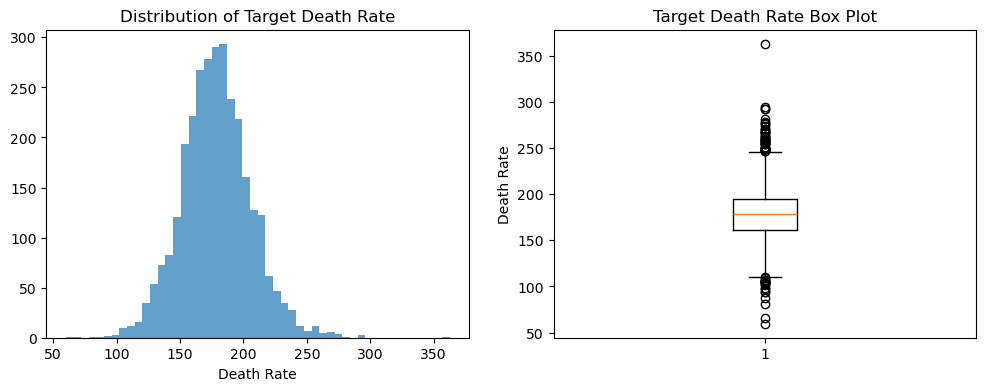

In [14]:
# 2. Target Variable Analysis
print("\nTarget Variable (target_deathrate) Analysis:")
print(df['TARGET_deathRate'].describe())

# Plot target distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['TARGET_deathRate'], bins=50, alpha=0.7)
plt.title('Distribution of Target Death Rate')
plt.xlabel('Death Rate')

plt.subplot(1, 2, 2)
plt.boxplot(df['TARGET_deathRate'])
plt.title('Target Death Rate Box Plot')
plt.ylabel('Death Rate')
plt.show()

In [15]:
# 3. Missing Values Analysis
print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])


Missing Values:
                     Column  Missing_Count  Missing_Percentage
17          PctSomeCol18_24           2285           74.991795
24  PctPrivateCoverageAlone            609           19.986872
21       PctEmployed16_Over            152            4.988513


In [16]:
# 4. Data Types and Unique Values
print("\nData Types and Unique Value Counts:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}, Unique: {df[col].nunique()}")


Data Types and Unique Value Counts:
avgAnnCount: float64, Unique: 929
avgDeathsPerYear: int64, Unique: 608
TARGET_deathRate: float64, Unique: 1053
incidenceRate: float64, Unique: 1506
medIncome: int64, Unique: 2920
popEst2015: int64, Unique: 2999
povertyPercent: float64, Unique: 333
studyPerCap: float64, Unique: 1117
binnedInc: object, Unique: 10
MedianAge: float64, Unique: 325
MedianAgeMale: float64, Unique: 298
MedianAgeFemale: float64, Unique: 296
Geography: object, Unique: 3047
AvgHouseholdSize: float64, Unique: 199
PercentMarried: float64, Unique: 362
PctNoHS18_24: float64, Unique: 405
PctHS18_24: float64, Unique: 469
PctSomeCol18_24: float64, Unique: 343
PctBachDeg18_24: float64, Unique: 219
PctHS25_Over: float64, Unique: 361
PctBachDeg25_Over: float64, Unique: 281
PctEmployed16_Over: float64, Unique: 409
PctUnemployed16_Over: float64, Unique: 195
PctPrivateCoverage: float64, Unique: 498
PctPrivateCoverageAlone: float64, Unique: 459
PctEmpPrivCoverage: float64, Unique: 450
PctPu

In [19]:
# Data Cleaning Steps - Updated

# 1. Handle Missing Values
# For numerical columns with missing values
numerical_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Before cleaning - Missing values summary:")
print(f"Total missing values: {df.isnull().sum().sum()}")

# Strategy for numerical missing values
columns_to_drop = []
for col in numerical_cols:
    missing_pct = df[col].isnull().sum() / len(df)
    if missing_pct > 0:
        if missing_pct > 0.5:  # Drop columns with >50% missing
            print(f"Dropping {col}: {missing_pct * 100:.1f}% missing")
            columns_to_drop.append(col)
        else:
            # Fill with median for skewed distributions - using correct pandas syntax
            df[col] = df[col].fillna(df[col].median())
            print(f"Filled {col} missing values with median: {missing_pct * 100:.1f}% missing")

# Drop columns with excessive missing values
if columns_to_drop:
    df = df.drop(columns=columns_to_drop)
    print(f"Dropped {len(columns_to_drop)} columns with >50% missing values")

# For categorical columns
for col in categorical_cols:
    missing_pct = df[col].isnull().sum() / len(df)
    if missing_pct > 0:
        if missing_pct > 0.5:
            print(f"Consider dropping categorical column {col}: {missing_pct * 100:.1f}% missing")
        else:
            # Fill with mode - using correct pandas syntax
            df[col] = df[col].fillna(df[col].mode()[0])
            print(f"Filled {col} missing values with mode: {missing_pct * 100:.1f}% missing")

print(f"\nAfter cleaning - Total missing values: {df.isnull().sum().sum()}")
print(f"Dataset shape after cleaning: {df.shape}")

Before cleaning - Missing values summary:
Total missing values: 2285
Dropping PctSomeCol18_24: 75.0% missing
Dropped 1 columns with >50% missing values

After cleaning - Total missing values: 0
Dataset shape after cleaning: (3047, 33)


In [20]:
# 2. Outlier Detection and Treatment
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

# Check for outliers in key columns
outlier_summary = {}
for col in numerical_cols:
    if col in df.columns:  # Check if column still exists after dropping
        outliers = detect_outliers_iqr(df[col])
        outlier_count = outliers.sum()
        outlier_pct = (outlier_count / len(df)) * 100
        outlier_summary[col] = {'count': outlier_count, 'percentage': outlier_pct}
        
        if outlier_pct > 5:  # Report columns with >5% outliers
            print(f"{col}: {outlier_count} outliers ({outlier_pct:.1f}%)")

# Optional: Cap outliers instead of removing them (better for medical data)
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    lower_cap = series.quantile(lower_percentile/100)
    upper_cap = series.quantile(upper_percentile/100)
    return series.clip(lower=lower_cap, upper=upper_cap)

# Apply capping to highly skewed columns if needed
# Example: df['column_name'] = cap_outliers(df['column_name'])

avgAnnCount: 461 outliers (15.1%)
avgDeathsPerYear: 349 outliers (11.5%)
popEst2015: 412 outliers (13.5%)
studyPerCap: 504 outliers (16.5%)
AvgHouseholdSize: 201 outliers (6.6%)
PctWhite: 174 outliers (5.7%)
PctBlack: 395 outliers (13.0%)
PctAsian: 323 outliers (10.6%)
PctOtherRace: 297 outliers (9.7%)
BirthRate: 164 outliers (5.4%)


In [21]:
# 3. Verify data quality after cleaning
print("Final Data Quality Summary:")
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Remove duplicates if any
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f"Removed {df.duplicated().sum()} duplicate rows")
    print(f"Final dataset shape: {df.shape}")

# Display summary of remaining columns
print(f"\nRemaining columns ({len(df.columns)}):")
for col in df.columns:
    print(f"  {col}: {df[col].dtype}")

Final Data Quality Summary:
Dataset shape: (3047, 33)
Missing values: 0
Duplicate rows: 0

Remaining columns (33):
  avgAnnCount: float64
  avgDeathsPerYear: int64
  TARGET_deathRate: float64
  incidenceRate: float64
  medIncome: int64
  popEst2015: int64
  povertyPercent: float64
  studyPerCap: float64
  binnedInc: object
  MedianAge: float64
  MedianAgeMale: float64
  MedianAgeFemale: float64
  Geography: object
  AvgHouseholdSize: float64
  PercentMarried: float64
  PctNoHS18_24: float64
  PctHS18_24: float64
  PctBachDeg18_24: float64
  PctHS25_Over: float64
  PctBachDeg25_Over: float64
  PctEmployed16_Over: float64
  PctUnemployed16_Over: float64
  PctPrivateCoverage: float64
  PctPrivateCoverageAlone: float64
  PctEmpPrivCoverage: float64
  PctPublicCoverage: float64
  PctPublicCoverageAlone: float64
  PctWhite: float64
  PctBlack: float64
  PctAsian: float64
  PctOtherRace: float64
  PctMarriedHouseholds: float64
  BirthRate: float64
